# ML Predictive Modeling - Purchase Incidence & Price Elasticity of Purchase Probability by Segment using Binary Logistic Regression


$\hookrightarrow$ **Will a customer buy a product from a particular product category when they enter the shop?**

We will arrive at the answer using a statistical model logistic regression that estimates purchase probability for each customer at each shopping trip. We use Logistic Regression because it is a neat and straightforward approach which can be easily interpreted. Then, we'll calculate the price elasticity of purchase probability under different conditions.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set_style("whitegrid")

## Data Preparation

In [2]:
#load data
df_purchase = pd.read_csv('DATA/purchase data.csv')

# Import pickle models
scaler = pickle.load(open('Models/00-scaler.pickle', 'rb'))
pca = pickle.load(open('Models/01-pca.pickle', 'rb'))
kmeans_pca = pickle.load(open('Models/02-kmeans_pca.pickle', 'rb'))

# Filter dataframe to 7 features
features = df_purchase[['Sex', 'Marital status',
                        'Age', 'Education', 'Income',
                        'Occupation', 'Settlement size']]
# Standardization
df_purchase_segm_std = scaler.transform(features)

# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the dataframe
df_purchase_predictors = df_purchase.copy()

# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca,
                                 prefix = 'Segment',
                                 prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies],
                                   axis = 1)
# Set name to full dataframe
df_pa = df_purchase_predictors

## Purchase Probability Model - Logistic Regression

We want to know whether a purchase has happened based on the average price of a product. Though there are different brands of candy bars right now, **we are only interested in whether a purchase will occur at all**. With that in mind, let's create a variable representing price irrespective of the brand.

We have a few options here. We can take the minimum or maximum price, which are good indicators of how expensive a product is in general. For instance, a brand new iPhone would be in the range between 400.0 and 1.000 dollars (both the minimum price and the maximum price are indicative here) or in another case imagine a house, on the contrary, would not cost less than 5.000, 10.000 or 50.000 dollars, depending on a variety of factors, however, its maximum price may be in the millions of dollars (maybe a maximum price here would not be as useful).

Other useful measures are **mean price and median price, these two are the two most common ways to represent an average, this model quantifies the exact relationship between price and probability of purchase**.

In [3]:
# Set input and output variables
y = df_pa['Incidence']

X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

X

,Mean_Price
0,2.044
1,2.028
2,2.028
3,2.028
4,2.030
...,...
58688,2.060
58689,2.060
58690,2.086
58691,2.092


In [4]:
# Logistic regression model
# solver='sag', is optimal for simple problems with large datasets like this one

model_purchase = LogisticRegression(solver='sag')
model_purchase.fit(X, y)

LogisticRegression(solver='sag')

In [5]:
# The coefficients for price interpretation

for i in model_purchase.coef_:
    if i < 0:
        print(f"Price Coefficient Value = {i[0]:.5f}\n")
        print("Interpretation of Coefficient:\nThe coefficients for price,", 
              "is negative signals that, with an increase in price,\t",
              "the purchase probability decreases",
              end=" ")
    else:
        print(f"Price Coefficient Value = {i[0]:.5f}\n")
        print("""The coefficients for price, is positive, signals that,
            with an increase in price, the purchase probability increases""")

Price Coefficient Value = -2.34682

Interpretation of Coefficient:
The coefficients for price, is negative signals that, with an increase in price,	 the purchase probability decreases 

## Calculate Price Elasticity of Purchase Probability


We just estimated our logistic regression model and now we can use the results to calculate the price elasticity of purchase probability.


> **TIP**: The Price Elasticity of Purchase Probability is the percentage change in purchase probability and response to a 1% change in price for the product category.



We have information about the change in purchase probability, given a price, that's what the logistic regression coefficient is showing. Therefore, we want to check different values for the mean price and see how they affect the purchase probability.

Since we are programming, we can define a range of prices and analyze each one of them. It is most logical to see the range of prices available in our data set first, lo let's apply the `.describe()` on out dataframe to examine the limits of our dataset.


In [6]:
# Prices for the five different brands, important in determining purchase probability 
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe().T

,count,mean,std,min,25%,50%,75%,max
Price_1,58693.0,1.392074,0.091139,1.10,1.34,1.39,1.47,1.59
Price_2,58693.0,1.780999,0.170868,1.26,1.58,1.88,1.89,1.90
Price_3,58693.0,2.006789,0.046867,1.87,1.97,2.01,2.06,2.14
Price_4,58693.0,2.159945,0.089825,1.76,2.12,2.17,2.24,2.26
Price_5,58693.0,2.654798,0.098272,2.11,2.63,2.67,2.70,2.80


In [7]:
# Set price range for which we'll examine the purchase probability (step 1 cent)
price_range = np.arange(0.5, 3.5, 0.01)

# Save price range in a dataframe
df_price_range = pd.DataFrame(price_range)
df_price_range.shape

(300, 1)

$$\textit{Purchase Probability Elasticity (E)} = \frac{\frac{\Delta Pr(purchase)}{Pr(purchase)}}{\frac{\Delta Price}{Price}} = \frac{\Delta Pr(purchase)}{\Delta Price}·\frac{Price}{Pr(purchase)}$$

$$\Rightarrow E = \beta · Price · (1 - Pr(purchase))$$

In [8]:
# Predict the purchase probability for defined price range
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [9]:
# Create price elasticities (pe) dataframe contain all the elasticities
df_price_elasticities = pd.DataFrame(price_range)

df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe

df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096305
1,0.51,-0.100368
2,0.52,-0.104558
3,0.53,-0.108877
4,0.54,-0.113330
...,...,...
295,3.45,-8.008319
296,3.46,-8.033562
297,3.47,-8.058770
298,3.48,-8.083944


## Analyze the Results of Price Elasticity of Purchase Probability

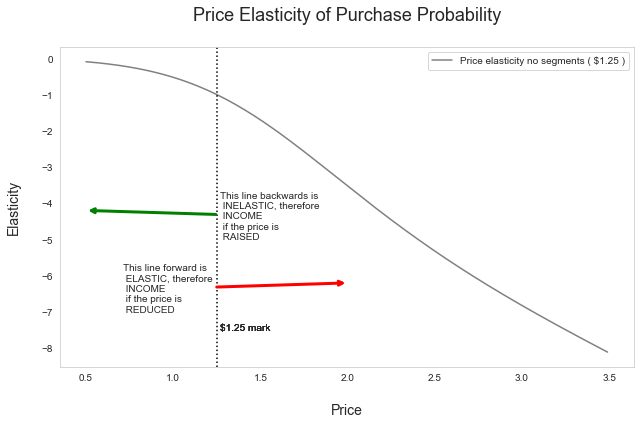

In [10]:
# Plot price elasticity of purchase probability of the average customer
# We observe that the price elasticities are all negative

plt.figure(figsize = (9, 6))

plt.plot(price_range, pe, color='grey', label="Price elasticity no segments ( $1.25 )")
plt.axvline(1.25, **{'lw': 1.5, 'alpha': 1, 'ls': ':', 'color': 'black'})
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Probability\n', fontsize=18)

# Mark down (bold effect)
plt.annotate('$1.25 mark', xy=(1.22, -7.5) ,xytext=(1.27, -7.5))
plt.annotate('$1.25 mark', xy=(1.22, -0.5) ,xytext=(1.27, -7.5))
plt.annotate('$1.25 mark', xy=(1.22, -0.5) ,xytext=(1.27, -7.5))
plt.annotate('$1.25 mark', xy=(1.22, -0.5) ,xytext=(1.27, -7.5))

# Increase price line
plt.annotate(
# Label and coordinate
    'This line backwards is\n INELASTIC, therefore\n INCOME\n if the price is\n RAISED',
    xy=(0.5, -4.2), xytext=(1.27, -5),
    # Custom arrow
    arrowprops=dict(arrowstyle='->',lw=3, color='green'))

# Reduce price line    
plt.annotate(
    # Label and coordinate
    'This line forward is\n ELASTIC, therefore\n INCOME\n if the price is\n REDUCED',
    xy=(2, -6.20), xytext=(0.71, -7),
    # Custom arrow
    arrowprops=dict(arrowstyle='->',lw=3, color='red'))

plt.tight_layout()
plt.legend()
plt.grid(False)
plt.show()

We can see the entire elasticity curve and how it changes compared to the price range as a function, the price elasticity decreases as price increases, meaning the higher the price of a product becomes, the less likely it will be for people to want to buy it.


**What is interesting, though, is at what rate this happens**. Let's see, the decrease in price is slow in the range between zero point five and one point one, and then it becomes steeper after the one point one mark. The other important observation we make is that the price elasticities are all negative.


By definition, **elasticity measures the percent change in an output variable, in our case purchase probability, given a percent change in an input variable or in our case, price**. Now, **if this percent change is greater than 100 percent, we say that the output or purchase probability is called elastic**.

On the other hand, **for changes less than 100 percent, it is inelastic**. In other words, if the elasticity has a value smaller than one, in absolute terms, we say it is inelastic. If it is greater than one, we say it is elastic.

In this case, **the elasticity of purchase probability is elastic**. This is an important distinction, and the reason is that **for inelastic values, the general recommendation is to increase the price** as it wouldn't cause a significant decrease in the output variable or in our case, purchase probability. On the other hand, **if we have the elasticity, which is greater than one in absolute terms, we should decrease our prices**.


> **TIP**: If is elastic, recommended to lower price, if inelastic, recommended to increase prices.



Now that we've elaborated on that, we can find the price elasticities which are elastic and the ones which are inelastic, the elasticity is steadily decreasing. Therefore, in our graph, it starts from being inelastic and then switches to being elastic.

Let's track down the precise point at which this happens, from the table we observed this happens at the 1.25 mark (price elastisity = -1.0).



And that brings us to the following **conclusion**:
1. For prices lower than 1.25, we can increase our product price without losing too much in terms of purchase probability.
2. For prices higher than 1.25 we have more to gain by reducing our prices.


The next step is to take advantage that we have segmented our customers dataset, so we'll see how to estimate the purchase elasticities for the different segments.

## Purchase Probability by Segments

### $\hookrightarrow \color{blue} {\text{Segment 0 - Standard}}$

In [11]:
# Select only customers from segment 0 
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]

# Prepare dependant and independant variables.
y = df_pa_segment_0['Incidence']
X = pd.DataFrame()
# Calculate average price segment 0
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5

# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver='sag')
model_incidence_segment0.fit(X, y)

# Retrieve beta (coefficient)
model_incidence_segment0.coef_

# Predict purchase probability
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]

# Calculate price elasticity purchase probability
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range * \
                            ( 1- purchase_pr_segment0)
# Save values in hte dataframe
df_price_elasticities['PE_Segment_0'] = pe_segment0
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0
0,0.50,-0.096305,-0.211792
1,0.51,-0.100368,-0.218378
2,0.52,-0.104558,-0.225072
3,0.53,-0.108877,-0.231874
4,0.54,-0.113330,-0.238786
...,...,...,...
295,3.45,-8.008319,-5.050911
296,3.46,-8.033562,-5.067756
297,3.47,-8.058770,-5.084583
298,3.48,-8.083944,-5.101392


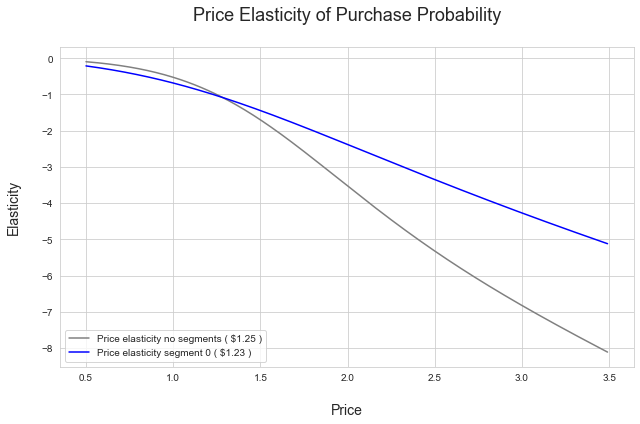

In [12]:
# Plot
plt.figure(figsize = (9, 6))

plt.plot(price_range, pe, color='grey', label="Price elasticity no segments ( $1.25 )")
plt.plot(price_range, pe_segment0, color='blue', label="Price elasticity segment 0 ( $1.23 )")
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Probability\n', fontsize=18)

plt.tight_layout()
plt.legend(loc=3)
plt.show()

### $\hookrightarrow \color{green} {\text{Segment 1 - Career-Focused}}$

In [13]:
# Select only customers from segment 1 
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

# Prepare dependant and independant variables.
y = df_pa_segment_1['Incidence']
X = pd.DataFrame()
# Calculate average price segment 1
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

# Logistic regression model
model_incidence_segment1 = LogisticRegression(solver='sag')
model_incidence_segment1.fit(X, y)

# Retrieve beta (coefficient)
model_incidence_segment1.coef_

# Predict purchase probability
Y_segment_1 = model_incidence_segment1.predict_proba(df_price_range)
purchase_pr_segment1 = Y_segment_1[:][: , 1]

# Calculate price elasticity purchase probability
pe_segment1 = model_incidence_segment1.coef_[:,0] * price_range * \
                            ( 1- purchase_pr_segment1)
# Save values in the dataframe
df_price_elasticities['PE_Segment_1'] = pe_segment1
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1
0,0.50,-0.096305,-0.211792,-0.119463
1,0.51,-0.100368,-0.218378,-0.123659
2,0.52,-0.104558,-0.225072,-0.127948
3,0.53,-0.108877,-0.231874,-0.132333
4,0.54,-0.113330,-0.238786,-0.136814
...,...,...,...,...
295,3.45,-8.008319,-5.050911,-5.683827
296,3.46,-8.033562,-5.067756,-5.703978
297,3.47,-8.058770,-5.084583,-5.724092
298,3.48,-8.083944,-5.101392,-5.744170


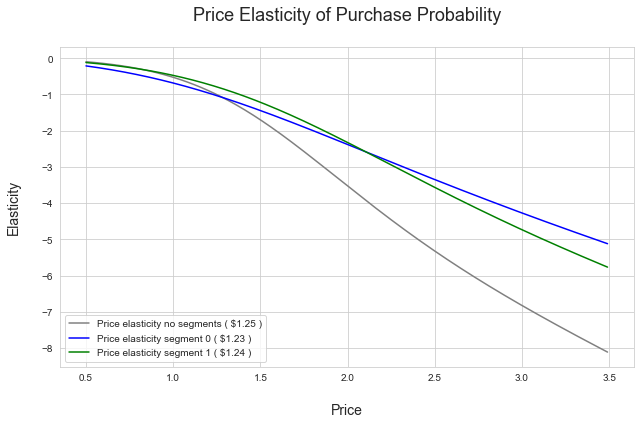

In [14]:
# Plot
plt.figure(figsize = (9, 6))

plt.plot(price_range, pe, color='grey', label="Price elasticity no segments ( $1.25 )")
plt.plot(price_range, pe_segment0, color='blue', label="Price elasticity segment 0 ( $1.23 )")
plt.plot(price_range, pe_segment1, color='green', label="Price elasticity segment 1 ( $1.24 )")
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Probability\n', fontsize=18)

plt.tight_layout()
plt.legend(loc=3)
plt.show()

### $\hookrightarrow \color{red} {\text{Segment 2 - Fewer-Opportunities}}$

In [15]:
# Select only customers from segment 2 
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]

# Prepare dependant and independant variables.
y = df_pa_segment_2['Incidence']
X = pd.DataFrame()
# Calculate average price segment 2
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

# Logistic regression model
model_incidence_segment2 = LogisticRegression(solver='sag')
model_incidence_segment2.fit(X, y)

# Retrieve beta (coefficient)
model_incidence_segment2.coef_

# Predict purchase probability
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]

# Calculate price elasticity purchase probability
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * \
                            ( 1- purchase_pr_segment2)
# Save values in hte dataframe
df_price_elasticities['PE_Segment_2'] = pe_segment2
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2
0,0.50,-0.096305,-0.211792,-0.119463,-0.030855
1,0.51,-0.100368,-0.218378,-0.123659,-0.032618
2,0.52,-0.104558,-0.225072,-0.127948,-0.034468
3,0.53,-0.108877,-0.231874,-0.132333,-0.036409
4,0.54,-0.113330,-0.238786,-0.136814,-0.038444
...,...,...,...,...,...
295,3.45,-8.008319,-5.050911,-5.683827,-12.544006
296,3.46,-8.033562,-5.067756,-5.703978,-12.580930
297,3.47,-8.058770,-5.084583,-5.724092,-12.617837
298,3.48,-8.083944,-5.101392,-5.744170,-12.654728


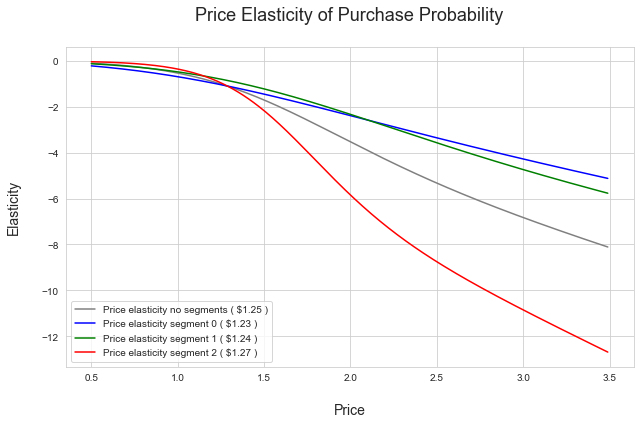

In [16]:
# Plot
plt.figure(figsize = (9, 6))

plt.plot(price_range, pe, color='grey', label="Price elasticity no segments ( $1.25 )")
plt.plot(price_range, pe_segment0, color='blue', label="Price elasticity segment 0 ( $1.23 )")
plt.plot(price_range, pe_segment1, color='green', label="Price elasticity segment 1 ( $1.24 )")
plt.plot(price_range, pe_segment2, color='red', label="Price elasticity segment 2 ( $1.27 )")
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Probability\n', fontsize=18)

plt.tight_layout()
plt.legend(loc=3)
plt.show()

### $\hookrightarrow \color{orange} {\text{Segment 3 - Well-Off}}$

In [17]:
# Select only customers from segment 3 
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]

# Prepare dependant and independant variables.
y = df_pa_segment_3['Incidence']
X = pd.DataFrame()
# Calculate average price segment 3
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5

# Logistic regression model
model_incidence_segment3 = LogisticRegression(solver='sag')
model_incidence_segment3.fit(X, y)

# Retrieve beta (coefficient)
model_incidence_segment3.coef_

# Predict purchase probability
Y_segment_3 = model_incidence_segment3.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]

# Calculate price elasticity purchase probability
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range * \
                            ( 1- purchase_pr_segment3)
# Save values in hte dataframe
df_price_elasticities['PE_Segment_3'] = pe_segment3
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096305,-0.211792,-0.119463,-0.030855,-0.168029
1,0.51,-0.100368,-0.218378,-0.123659,-0.032618,-0.172953
2,0.52,-0.104558,-0.225072,-0.127948,-0.034468,-0.177948
3,0.53,-0.108877,-0.231874,-0.132333,-0.036409,-0.183013
4,0.54,-0.113330,-0.238786,-0.136814,-0.038444,-0.188149
...,...,...,...,...,...,...
295,3.45,-8.008319,-5.050911,-5.683827,-12.544006,-4.021566
296,3.46,-8.033562,-5.067756,-5.703978,-12.580930,-4.036432
297,3.47,-8.058770,-5.084583,-5.724092,-12.617837,-4.051282
298,3.48,-8.083944,-5.101392,-5.744170,-12.654728,-4.066115


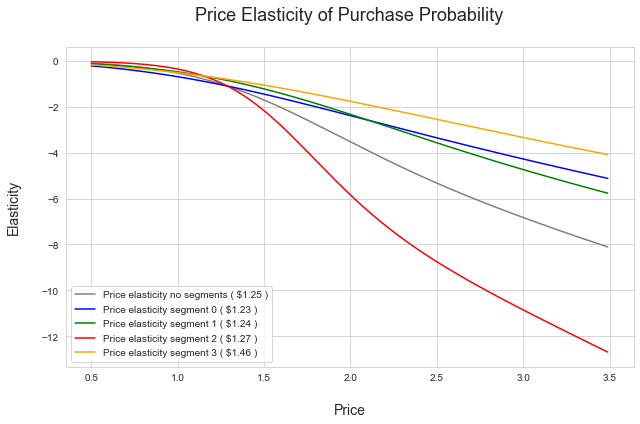

In [18]:
# Plot
plt.figure(figsize = (9, 6))

plt.plot(price_range, pe, color='grey', label="Price elasticity no segments ( $1.25 )")
plt.plot(price_range, pe_segment0, color='blue', label="Price elasticity segment 0 ( $1.23 )")
plt.plot(price_range, pe_segment1, color='green', label="Price elasticity segment 1 ( $1.24 )")
plt.plot(price_range, pe_segment2, color='red', label="Price elasticity segment 2 ( $1.27 )")
plt.plot(price_range, pe_segment3, color='orange', label="Price elasticity segment 3 ( $1.46 )")
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Probability\n', fontsize=18)

plt.tight_layout()
plt.legend(loc=3)
plt.show()

## Purchase Probability with Promotion Feature


We've now successfully completed the analysis by segments based on price, rest assured that **in any purchase analytics model you ever create, price will be the most prominent feature**. However, there might be other factors which affect a customer's decision whether to buy a product as well.

You may remember from our introductory lectures that one of the four PS was promotion. This basically means that a product's price could be temporarily reduced or other types of promotions such as display or feature, may come into play. So product promotion may affect purchase probability. Therefore, for this model will incorporate a promotion feature to see its effect on elasticity, as was the case for the brand.

We'll model using the entire data set and examine the importance of promotions for all customers, if you like, you can refine the model to reflect only a particular segment.

### Data Preparation

In [19]:
# Set variables
y = df_pa['Incidence']

X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [20]:
# We include a second promotion feature.
# We'd like to examine the effects of promotions on purchase probability.
# We calculate the average promotion rate across the five brands.
# We add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [21]:
# The coefficient for promotion is positive. 
# Therefore, there is a positive relationship between promotion and purchase probability.

model_incidence_promotion = LogisticRegression(solver='sag')
model_incidence_promotion.fit(X, y)
model_incidence_promotion.coef_

array([[-1.49392724,  0.56151392]])

## Price Elasticity with Promotion

In [22]:
# We create a data frame on which our model will predict.
# We need to include A price and promotion feature.
# First, we'll include the price range as the price feature.
# Next, we'll include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion \
                                        .rename(columns = {0: "Price_Range"})

In [23]:
# We'll calculate price elasticities of purchase probability when we assume
# there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [24]:
# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

In [25]:
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) \
                                                                * (1 - promo)

In [26]:
# Update dataframe to include elasticities of purchase probability with promo feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1
0,0.50,-0.096305,-0.211792,-0.119463,-0.030855,-0.168029,-0.125725
1,0.51,-0.100368,-0.218378,-0.123659,-0.032618,-0.172953,-0.129841
2,0.52,-0.104558,-0.225072,-0.127948,-0.034468,-0.177948,-0.134036
3,0.53,-0.108877,-0.231874,-0.132333,-0.036409,-0.183013,-0.138310
4,0.54,-0.113330,-0.238786,-0.136814,-0.038444,-0.188149,-0.142666
...,...,...,...,...,...,...,...
295,3.45,-8.008319,-5.050911,-5.683827,-12.544006,-4.021566,-4.861224
296,3.46,-8.033562,-5.067756,-5.703978,-12.580930,-4.036432,-4.879425
297,3.47,-8.058770,-5.084583,-5.724092,-12.617837,-4.051282,-4.897596
298,3.48,-8.083944,-5.101392,-5.744170,-12.654728,-4.066115,-4.915736


## Price Elasticity without Promotion

In [27]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no \
                                            .rename(columns = {0: "Price_Range"})

In [28]:
# Promotion feature -No Promotion.
# We assume there aren't any promotional activities on any of the price points.
# We examine the elasticity of purchase probability when there isn't promotion.
df_price_elasticity_promotion_no['Promotion'] = 0

In [29]:
#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

In [30]:
no_promo = Y_no_promo[: , 1]

In [31]:
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range \
                                                                  * (1- no_promo)

In [32]:
# Update df to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo

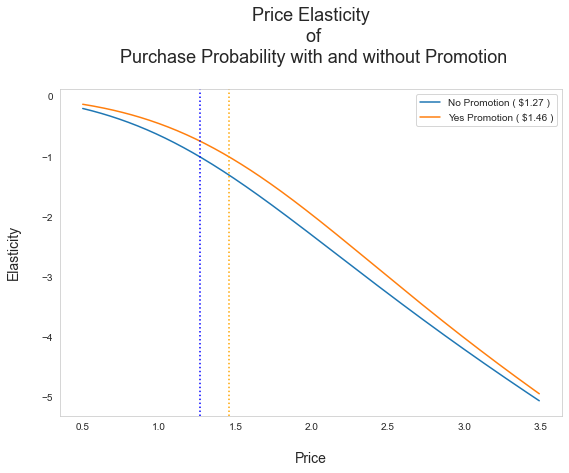

In [33]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.
# Observe that purchase probability elasticity of customer is less elastic when there is promotion.

# This is an important insight for marketers, as according to our model people are more likely to buy a product if there is
# some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 
plt.figure(figsize = (9, 6))

plt.plot(price_range, price_elasticity_no_promo, label='No Promotion ( $1.27 )')
plt.plot(price_range, price_elasticity_promo, label='Yes Promotion ( $1.46 )')
plt.axvline(1.27, **{'lw': 1.5, 'alpha': 1, 'ls': ':', 'color': 'blue'})
plt.axvline(1.46, **{'lw': 1.5, 'alpha': 1, 'ls': ':', 'color': 'orange'})
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity\n of\n Purchase Probability with and without Promotion\n',
         fontsize=18)

plt.legend(loc=0)
plt.grid(False)
plt.show()

These two lines represent the elasticity of purchase probability, given maximum and given minimum promotional activity. This graph here tells us that the elasticity curve with promotion sits above its respective no promotion counterpart for the entire price range.

Additionally, if we see our dataframe, we can see that in elasticity for No Promotion ends at 1.27 dollar while for Yes Promotion at 1.46 dollars. That's a difference of almost 0.20 cents. So if a product has a regular price of 1.30 dollars, the purchase probability is elastic.

However, if a product cost 1.50 dollars on the regular (No Promotion) and its price is reduced to 1.30  dollars during a Promotion, then our analysis says that purchase probability is still inelastic at this point.

This may sound trivial, but it is not, think about it. People are more willing to buy products at promotional prices, be it because of the large discount signs in some stores, or just because psychologically people feel they're getting a bargain.

According to this model, if we could incorporate it, it would be more beneficial to have a higher original price and constant promotion rather than a lower original price.

---

# ML Predictive Modeling - Brand Choice by Segment using Multiclass Logistic Regression

## Purchase Probability Model

In [34]:
# Set input and output variables
brand_choice = df_pa[df_pa['Incidence'] == 1]
brand_choice

# Set dependent variable (multi-class)
y = brand_choice['Brand']

# Set independent variables
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

X

,Price_1,Price_2,Price_3,Price_4,Price_5
6,1.50,1.90,1.99,2.09,2.67
11,1.39,1.90,1.91,2.12,2.62
19,1.47,1.90,1.99,1.97,2.67
24,1.21,1.35,1.99,2.16,2.68
29,1.46,1.88,1.97,1.89,2.37
...,...,...,...,...,...
58621,1.48,1.89,2.01,2.18,2.69
58648,1.35,1.57,2.02,2.21,2.70
58674,1.50,1.85,2.06,2.24,2.79
58687,1.42,1.51,1.97,2.24,2.78


In [35]:
# Miltinomial logistic regression
model_brand_choice = LogisticRegression(solver ='sag', 
                                        multi_class='multinomial')
model_brand_choice.fit(X, y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [36]:
# Here are the coeffictients for the model. We have five brands and five features for the price. 
# Therefore, this output is somewhat difficult to read.
model_brand_choice.coef_

# Save coefficients in dataframe with labels
bc_coef = pd.DataFrame(model_brand_choice.coef_)

bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coeffs = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coeffs]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(3)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.916,1.275,1.624,0.575,0.443
Price_2,0.658,-1.880,0.562,0.396,0.264
Price_3,2.418,-0.213,0.501,-1.401,-1.305
Price_4,0.704,-0.206,1.039,-1.246,-0.291
Price_5,-0.202,0.588,0.453,0.249,-1.088


Let's interpret the coefficients results and what they mean.

Let's start with brand 1, the coefficient for the own brand with respect to prices is negative, while it's positive for all other prices except for price 5 (we already know that the higher the price of the product, the lower the probability for it to be purchased by a customer), so it makes sense for the brand price coefficient to be negative.

On the other hand, the more the price of a competitor increases, the higher the probability of customers switching to our own brand would be. Hence, there is a positive relationship between our own brands purchase probability and a competitor brand increasing their price.

Well, at this point, you may have realized that the choice probability for any specific brand and the choice probabilities for all the rest of the brands are interrelated. In Marketing Mix tool of our brand reflects not only the choice probability for that brand, but the choice probabilities for all other brands as well. These effects are known as **Own Brand Effects** and **Cross Brand Effects**.

## Own Price Elasticity for Brand 5

Performing brand choice analysis is extremely useful from a brand perspective, therefore will concentrate on a specific brand to gain insight into developing a strategy to target customers.

Suppose you are a marketing analyst working for Brand 5 the most expensive brand, of course, the technique can be applied to calculate elasticity of each one of the remaining brands.

What would you mainly be interested in knowing about brand 5?
- **Own Price Elasticity**: First, you would like to know the **effects of price changes to your own brand price** .
- **Cross Price Elasticity**: Then you'd like to know **what would happen if your competitors change the pricing**.

This information is contained in the *Own Price Elasticity* and the Cross Price Elasticities respectively.

In [37]:
# Calculate price elasticity of brand choice.
# Here we create a data frame with price columns, which our model will use to predict the brand choice probabilities.

# Set price range from 0.50 up to 3.50 dollars in steps of 1 cent
price_range = np.arange(0.5, 3.5, 0.01)

# Set price range from brand 5 ()
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))

df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


So essentially we'll be projecting the purchase probability of brand 5 for different price points. Let's create a variable predict brand five to calculate the predicted probabilities will apply the `.predict_proba()` method on our brand choice model. Naturally, the input data will come from the own brand 5 dataframe.

In [38]:
# Brand Choice Model prediction.
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [39]:
# Our model returns the probabilities of choosing each of the 5 brands. 
# Since, we are interested in the probability for the brand 5, we need the last column located on position 4.
pr_own_brand_5 = predict_brand_5[: ][:, 4]

# Beta or coef for brand 5. 
# Therefore, the beta coefficient we require is that of the brand 5 coefficient and price 5.
beta5 = bc_coef.iloc[4, 4]

We have everything we need to calculate price elasticities for purchase probability of Brand 5, it's time to use the elasticity formula (first notebook in this chapter). Note that this time will need the beta coefficient for the price of brand 5.

In [40]:
# Calculating price elasticities for brand 5 choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [41]:
# Adding the price elasticities to our master dataframe. 
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5
0,0.50,-0.096305,-0.211792,-0.119463,-0.030855,-0.168029,-0.125725,-0.195632,-0.048965
1,0.51,-0.100368,-0.218378,-0.123659,-0.032618,-0.172953,-0.129841,-0.201753,-0.050523
2,0.52,-0.104558,-0.225072,-0.127948,-0.034468,-0.177948,-0.134036,-0.207976,-0.052111
3,0.53,-0.108877,-0.231874,-0.132333,-0.036409,-0.183013,-0.138310,-0.214302,-0.053728
4,0.54,-0.113330,-0.238786,-0.136814,-0.038444,-0.188149,-0.142666,-0.220733,-0.055375
...,...,...,...,...,...,...,...,...,...
295,3.45,-8.008319,-5.050911,-5.683827,-12.544006,-4.021566,-4.861224,-4.982859,-3.225642
296,3.46,-8.033562,-5.067756,-5.703978,-12.580930,-4.036432,-4.879425,-4.999764,-3.241806
297,3.47,-8.058770,-5.084583,-5.724092,-12.617837,-4.051282,-4.897596,-5.016650,-3.257938
298,3.48,-8.083944,-5.101392,-5.744170,-12.654728,-4.066115,-4.915736,-5.033516,-3.274038


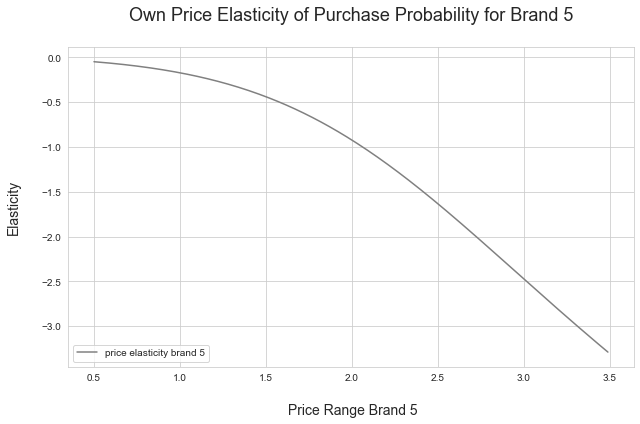

In [42]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))

plt.plot(price_range, own_price_elasticity_brand_5,
         color='grey',
         label='price elasticity brand 5')
plt.xlabel('\n Price Range Brand 5', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Own Price Elasticity of Purchase Probability for Brand 5\n', fontsize=18)
plt.legend(loc=3)
plt.tight_layout()
plt.show()

Overall, this result was intriguing, but not completely fulfilling. What interests us more is **what would happen to the purchase probability of Brand five if a competitor changed their pricing**.

## Cross Price Elasticity Brand 5, Cross Brand 4


We are ready to examine the relationship between Brand 5 (our brand) and a competitor, we could choose any of the remaining brands. However, we know that Brand 5 has the most expensive price, alone means nothing, but we can assume it is one of the highest quality.

Based on that, it seems that the brand which comes closest is Brand 4. Therefore, it would make the most sense to compare these two. Of course, we can examine Cross Price Elasticities for any of the remaining brands.

It's set, let's determine the Cross Price Elasticities of Brand 5 with respect to Brand 4. In essence, will follow the same steps as for calculating elasticities of the own brand price.

In [43]:
# We want to examine the effect of the changes in price of a competitor brand.
# As we've discussed in the lecture, the brand which comes closest to our own brand is brand 4. 
# Therefore, we need to examine changes in the price of this brand.
# Keep in mind, we could examine the cross price elasticities for any of the remaining brands, 
# we just need to update this data frame accordingly to contain the respective brand.
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))

# Estimate mean price for our brand 5 and the rest of brands that are not the target competitor.
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()

# Set price range to target competitor brand to analyze price change behavior
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()
df_brand5_cross_brand4

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,3.45,2.654296
296,1.384559,1.764717,2.006694,3.46,2.654296
297,1.384559,1.764717,2.006694,3.47,2.654296
298,1.384559,1.764717,2.006694,3.48,2.654296


It will contain price columns from one to five for each of the brands now cross price elasticity measures, the purchase probability for our own brand based on changes in the price of the competitor. Hence, **we'll need to examine changes in the price of Brand 4**. Therefore, the price for will contain the price range and the rest of the price series will contain a constant price. As usual, we will take the mean price for each of the brands except for brand 4 (target competitor).


The next step is to compute the probabilities by using our model brand choice using `.predict_proba()` method on our brand 5 cross brand 4 dataframe.

OK, we can proceed to computing price elasticities, here in order to calculate the Cross Price Elasticities, we'll use a different formula. Here's the simplified result.

$$\textit{Probability Cross Price Elasticity} = E = -\beta(\textit{own price})·Price(\textit{cross brand})·Pr(\textit{cross brand})$$

In [44]:
# Cross Price Elasticity formula requirements

# Predict probabilities
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

# As now we're interested in what the probability of choosing the competitor brand is, 
# we need to select the purchase probability for brand 4, contained in the 4th column with index 3. 
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]
predict_brand5_cross_brand4[:][:, ]

# Beta 5
beta5

-1.088

In [45]:
# In order to calculate the cross brand price elasticity, we need to use the new formula we introduced in the lecture.
# The elasticity is equal to negative the price coefficient of the own brand multiplied by the price of the cross brand,
# further multiplied by the probability for choosing the cross brand.
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

# Update price elasticities data frame to include the cross price elasticities for brand 5 with respect to brand 4.
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4
0,0.50,-0.096305,-0.211792,-0.119463,-0.030855,-0.168029,-0.125725,-0.195632,-0.048965,0.331402
1,0.51,-0.100368,-0.218378,-0.123659,-0.032618,-0.172953,-0.129841,-0.201753,-0.050523,0.336668
2,0.52,-0.104558,-0.225072,-0.127948,-0.034468,-0.177948,-0.134036,-0.207976,-0.052111,0.341878
3,0.53,-0.108877,-0.231874,-0.132333,-0.036409,-0.183013,-0.138310,-0.214302,-0.053728,0.347030
4,0.54,-0.113330,-0.238786,-0.136814,-0.038444,-0.188149,-0.142666,-0.220733,-0.055375,0.352126
...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.008319,-5.050911,-5.683827,-12.544006,-4.021566,-4.861224,-4.982859,-3.225642,0.161937
296,3.46,-8.033562,-5.067756,-5.703978,-12.580930,-4.036432,-4.879425,-4.999764,-3.241806,0.160041
297,3.47,-8.058770,-5.084583,-5.724092,-12.617837,-4.051282,-4.897596,-5.016650,-3.257938,0.158158
298,3.48,-8.083944,-5.101392,-5.744170,-12.654728,-4.066115,-4.915736,-5.033516,-3.274038,0.156290


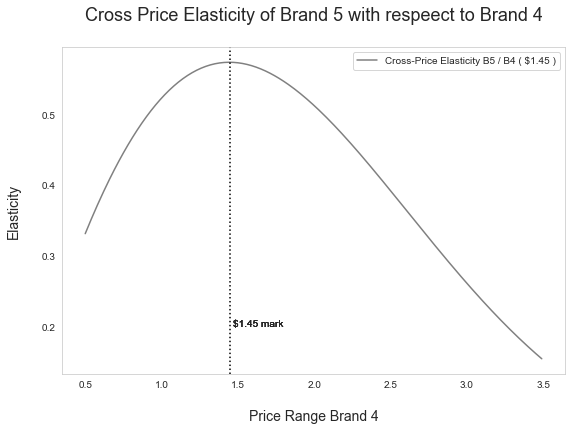

In [46]:
# We observe a positive relationship. As the price of the competitor brand increases, 
# so does the probability for purchasing our own brand.
# Even though the elasticity starts to decrease from the 1.45 mark, it is still positive, 
# signalling that the increase in purchase probability for the own brand happens more slowly.
plt.figure(figsize = (9, 6))

plt.plot(price_range,
         brand5_cross_brand4_price_elasticity,
         color='grey',
         label='Cross-Price Elasticity B5 / B4 ( $1.45 )')
plt.axvline(1.45, **{'lw': 1.5, 'alpha': 1, 'ls': ':', 'color': 'black'})

# Mark down (bold effect)
plt.annotate('$1.45 mark', xy=(1.46, 0.2) ,xytext=(1.47, 0.2))
plt.annotate('$1.45 mark', xy=(1.46, 0.2) ,xytext=(1.47, 0.2))
plt.annotate('$1.45 mark', xy=(1.46, 0.2) ,xytext=(1.47, 0.2))
plt.annotate('$1.45 mark', xy=(1.46, 0.2) ,xytext=(1.47, 0.2))

plt.xlabel('\nPrice Range Brand 4', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Cross Price Elasticity of Brand 5 with respeect to Brand 4\n', fontsize=18)

plt.legend()
plt.grid(False)
plt.show()

**Cross Price Elasticity Conclusions**

We have successfully obtained the cross price elasticities for the competitor brand, we observed that the elasticities are positive across the price range. This **indicates that if competitor brand for increases prices, the purchase probability for our own brand would increase**.

That's not surprising, our competitor raises prices and they start buying our product more. Once again, though, the elasticity show us exactly how much more. Depending on the cross price elasticities, we can actually gain insights about the market itself.

If the **Cross Price Elasticity is greater than zero, the two products are considered substitutes**. That's logical as brand 4 and brand 5, both are chocolate candy bars. If, however, we were looking at brand 5 crusts, some type of beer, for instance, therefore the cross price elasticity would not be necessarily be positive, as the two products have nothing in common.



OK, in our example, all across price elasticities will be positive as all brands are substitutes for one another. Furthermore, **if the price elasticity at some price point is greater in absolute terms than our own price elasticity, the alternative brand is considered a Strong Substitute**.

$\hookrightarrow$ **Is brand 4 a strong substitute for brand 5?**

Well, depends on the price point. You can graph the absolute values of the two elasticities or examine the elasticity dataframe. For this case, Brand 4 is a strong substitute for Brand 5 for all prices up to one dollar sixty five. However, we know that these prices are out of the natural domain of brand, for therefore **if Brand 4 had a substantially lower price, it would be a very strong competitor**.


It is important to mark that the observed price range of Brand 4 lies between 1.76 and 2.06, in this price range we observed the elasticity is steadily decreasing. This signals that with an increase in price, the purchase probability changes more slowly. Note, however, it is positive, therefore, our purchase probability still increases with the increase in price of Brand 4, but at a slower rate. With these observations in mind, we can conclude that when it comes to the average customer, brand 4 is an obviously a weak substitute for Brand 5.

In light of these results, Brand 5 can create a marketing strategy for targeting customers which choose brand for and attract them to buy the own brand. However, we already know that targeting the average customer can be a labor some, if not next to an impossible task, no brand can make everyone happy, but a brand can make a certain customer segment happy, which is why we will further refine our model and compute Own and Cross Price Elasticities by customer segments.

## Own and Cross-Price Elasticity by Segment

### $\hookrightarrow \color{orange}{\text{Segment 3: Well-Off}}$

In [47]:
# We are interested in analysing the purchase probability for choosing brand 5 by segments.
# Filter our data to contain only purchase incidences and are part of segment 3.
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 3]

brand_choice_s3

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,...,52,2,159052,2,1,3,0,0,0,1
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,...,52,2,159052,2,1,3,0,0,0,1
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,...,52,2,159052,2,1,3,0,0,0,1
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,...,52,2,159052,2,1,3,0,0,0,1
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,...,52,2,159052,2,1,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57346,200000489,687,1,4,1,4,1,1.50,1.87,2.06,...,44,2,193816,2,1,3,0,0,0,1
57347,200000489,693,1,4,2,4,1,1.42,1.51,2.02,...,44,2,193816,2,1,3,0,0,0,1
57348,200000489,701,1,4,3,4,1,1.42,1.85,1.99,...,44,2,193816,2,1,3,0,0,0,1
57350,200000489,715,1,4,2,0,0,1.50,1.80,2.09,...,44,2,193816,2,1,3,0,0,0,1


In [48]:
# Brand Choice Model estimation.

# Set dependent variable
y = brand_choice_s3['Brand']

# Create dummy variables
brand_choice_s3 = pd.get_dummies(brand_choice_s3,
                                 columns=['Brand'],
                                 prefix='Brand',
                                 prefix_sep='_')
# Set independent variable
X = brand_choice_s3[features]

# Logistic regression model
model_brand_choice_s3 = LogisticRegression(solver='sag',
                                           multi_class='multinomial',
                                           max_iter=300)
# Fit model
model_brand_choice_s3.fit(X, y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coeffs]
bc_coef.index = [prices]
bc_coef = bc_coef.round(23)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.151353,1.326279,0.817645,0.116771,-0.109343
Price_2,-0.958632,-1.381004,1.288114,0.779530,0.271992
Price_3,2.007825,-1.651646,-0.491413,0.028520,0.106715
Price_4,2.524324,0.957498,-0.254588,-1.896195,-1.331040
Price_5,-0.993644,-0.299761,1.173186,0.563220,-0.443000


### $\color{orange}{\text{Own-Brand Price Elasticity}}$

In [49]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand 5 S3'] = own_price_elasticity_brand_5_s3

### $\color{orange}{\text{Cross-Brand Price Elasticity}}$

In [50]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096305,-0.211792,-0.119463,-0.030855,-0.168029,-0.125725,-0.195632,-0.048965,0.331402,-0.296776,0.481536
1,0.51,-0.100368,-0.218378,-0.123659,-0.032618,-0.172953,-0.129841,-0.201753,-0.050523,0.336668,-0.302811,0.490824
2,0.52,-0.104558,-0.225072,-0.127948,-0.034468,-0.177948,-0.134036,-0.207976,-0.052111,0.341878,-0.308856,0.500097
3,0.53,-0.108877,-0.231874,-0.132333,-0.036409,-0.183013,-0.138310,-0.214302,-0.053728,0.347030,-0.314912,0.509354
4,0.54,-0.113330,-0.238786,-0.136814,-0.038444,-0.188149,-0.142666,-0.220733,-0.055375,0.352126,-0.320979,0.518595
...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.008319,-5.050911,-5.683827,-12.544006,-4.021566,-4.861224,-4.982859,-3.225642,0.161937,-3.331187,0.157190
296,3.46,-8.033562,-5.067756,-5.703978,-12.580930,-4.036432,-4.879425,-4.999764,-3.241806,0.160041,-3.344493,0.151778
297,3.47,-8.058770,-5.084583,-5.724092,-12.617837,-4.051282,-4.897596,-5.016650,-3.257938,0.158158,-3.357795,0.146532
298,3.48,-8.083944,-5.101392,-5.744170,-12.654728,-4.066115,-4.915736,-5.033516,-3.274038,0.156290,-3.371095,0.141446


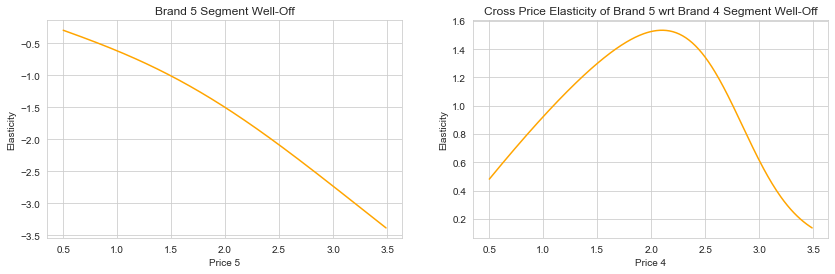

In [51]:
# Using a figure with axes we plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s3, color = 'orange')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel='Elasticity')

First, the Own Price Elasticity indicates that the well-off customer segment is elastic to our own brand 5. This was rather expected, as they seem to prefer brand 4. And if we check our descriptive analysis table (proportion table above), we can verify that indeed, over 60% of the
well-off segment purchased brand 4, and about 20% purchase brand 5.

Now to cross price elasticities, they are positive, indicating that for the well-off segment, brand 4 is indeed a substitute product for brand 5. There are a number of insights you can derive from this result (we mentioned most of them in the previous lessons, so we won't spend too much time on that). Instead, we will focus on a novel idea based on both graphs.

Let's first highlight the natural domains of the prices of Brand 5 and Brand 4. On the two graphs, say brand 5 costs 2.40 dollars so brand 5 Own Price Elasticity is -1.96. For brand 4, it cost 2.00 dollars, so the cross price elasticity is 1.53.


$\hookrightarrow$ **What would happen if our competitor brand reduce their prices by 1%?

Well, the cross price elasticity is 1.53, so **the purchase probability of our brand 5 will fall by -1.53%**. Sounds like a serious hit on our sales, but we can strike back. We can lower our own price by 1%.

In that case, we **must look at the own price elasticity of our brand 5, since it is -1% decrease in our price would be reflected in a +2% increase in purchase probability. The net effect of the two price decreases is 2% - 1.5% = +0.5%. Therefore, we have reacted to our competitors price range and have actually gained some market share**.

### $\hookrightarrow \color{blue}{\text{Segment 0: Standard}}$

In [52]:
# Here we are interesting in analysing the brand choice probability of the Standard segment.
# We filter our data, by selecting only purchases from segment 0.
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment'] == 0]
brand_choice_s0

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,...,32,1,88428,0,0,0,1,0,0,0
2403,200000024,98,1,2,2,0,0,1.47,1.90,1.95,...,32,1,88428,0,0,0,1,0,0,0
2408,200000024,143,1,2,3,0,0,1.21,1.35,1.99,...,32,1,88428,0,0,0,1,0,0,0
2410,200000024,162,1,2,5,0,0,1.39,1.90,1.94,...,32,1,88428,0,0,0,1,0,0,0
2417,200000024,217,1,5,1,0,0,1.34,1.89,1.99,...,32,1,88428,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58436,200000498,579,1,3,5,3,1,1.22,1.89,2.01,...,29,1,114784,1,0,0,1,0,0,0
58444,200000498,626,1,3,3,0,0,1.48,1.57,2.06,...,29,1,114784,1,0,0,1,0,0,0
58450,200000498,657,1,2,5,0,0,1.26,1.88,2.06,...,29,1,114784,1,0,0,1,0,0,0
58453,200000498,675,1,2,5,0,0,1.42,1.85,2.06,...,29,1,114784,1,0,0,1,0,0,0


In [53]:
# Brand Choice Model estimation.
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 200)
model_brand_choice_s0.fit(X, Y)

# Coefficients table segment 0.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coeffs]
bc_coef.index = [prices]
bc_coef = bc_coef.round(3)

### $\color{blue}{\text{Own-Brand Price Elasticity}}$

In [54]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

# Compute price elasticities and update master data frame.
# We'd like to include the elasticities for the segments in order from 0 to three, which is why we use insert() on position 10.
own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities.insert(10, column = 'Brand 5 S0', value = own_price_elasticity_brand_5_s0)

### $\color{blue}{\text{Cross-Brand Price Elasticity}}$

In [55]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Standard segment.
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

# Compute price elasticities and update master data frame.
# We need to use insert() on position 11, to save the price elasticities in the correct order.
brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities.insert(11, column = 'Brand_5_Cross_Brand_4_S0', value = brand5_cross_brand4_price_elasticity_s0)

### $\hookrightarrow \color{green}{\text{Segment 1: Career-Focused}}$

In [56]:
# Filter data by the Career-focused segment, which is the first segment.
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

In [57]:
# Brand Choice Model estimation.
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table segment 1
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coeffs]
bc_coef.index = [prices]
bc_coef = bc_coef.round(3)

### $\color{green}{\text{Own-Brand Price Elasticity}}$

In [58]:
# Calculating own-brand price elasticity for brand 5 and the Career-focused segment.
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities.insert(12, column = 'Brand 5 S1', value = own_price_elasticity_brand_5_s1)

### $\color{green}{\text{Cross-Brand Price Elasticity}}$

In [59]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Career-focused segment.
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities.insert(13, column = 'Brand_5_Cross_Brand_4_S1', value = brand5_cross_brand4_price_elasticity_s1)

### $\hookrightarrow \color{red}{\text{Segment 2: Fewer-Opportunities}}$

In [60]:
# Filter data, select only purchases from segment 2, which is the Fewer-Opportunities segment.
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]

In [61]:
# Brand Choice Model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table segment 2
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coeffs]
bc_coef.index = [prices]
bc_coef = bc_coef.round(3)

### $\color{red}{\text{Own-Brand Price Elasticity}}$

In [62]:
# Calculating own-brand price elasticity for brand 5 and the Fewer-opportunities segment.
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities.insert(14, column = 'Brand 5 S2', value = own_price_elasticity_brand_5_s2)

### $\color{red}{\text{Cross-Brand Price Elasticity}}$

In [63]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Fewer-opportunities segment.
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities.insert(15, column = 'Brand_5_Cross_Brand_4_S2', value = brand5_cross_brand4_price_elasticity_s2)
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096305,-0.211792,-0.119463,-0.030855,-0.168029,-0.125725,-0.195632,-0.048965,0.331402,-0.115598,0.173763,-0.043860,0.194409,-0.001034,0.181262,-0.296776,0.481536
1,0.51,-0.100368,-0.218378,-0.123659,-0.032618,-0.172953,-0.129841,-0.201753,-0.050523,0.336668,-0.118631,0.175815,-0.044944,0.196888,-0.001096,0.183555,-0.302811,0.490824
2,0.52,-0.104558,-0.225072,-0.127948,-0.034468,-0.177948,-0.134036,-0.207976,-0.052111,0.341878,-0.121699,0.177815,-0.046038,0.199317,-0.001161,0.185799,-0.308856,0.500097
3,0.53,-0.108877,-0.231874,-0.132333,-0.036409,-0.183013,-0.138310,-0.214302,-0.053728,0.347030,-0.124802,0.179765,-0.047142,0.201695,-0.001229,0.187994,-0.314912,0.509354
4,0.54,-0.113330,-0.238786,-0.136814,-0.038444,-0.188149,-0.142666,-0.220733,-0.055375,0.352126,-0.127941,0.181665,-0.048255,0.204023,-0.001300,0.190141,-0.320979,0.518595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.008319,-5.050911,-5.683827,-12.544006,-4.021566,-4.861224,-4.982859,-3.225642,0.161937,-3.585866,0.024015,-1.285058,0.068469,-3.739207,0.023364,-3.331187,0.157190
296,3.46,-8.033562,-5.067756,-5.703978,-12.580930,-4.036432,-4.879425,-4.999764,-3.241806,0.160041,-3.599745,0.023659,-1.294848,0.067847,-3.750628,0.022905,-3.344493,0.151778
297,3.47,-8.058770,-5.084583,-5.724092,-12.617837,-4.051282,-4.897596,-5.016650,-3.257938,0.158158,-3.613580,0.023308,-1.304694,0.067230,-3.762029,0.022453,-3.357795,0.146532
298,3.48,-8.083944,-5.101392,-5.744170,-12.654728,-4.066115,-4.915736,-5.033516,-3.274038,0.156290,-3.627370,0.022961,-1.314595,0.066617,-3.773411,0.022009,-3.371095,0.141446


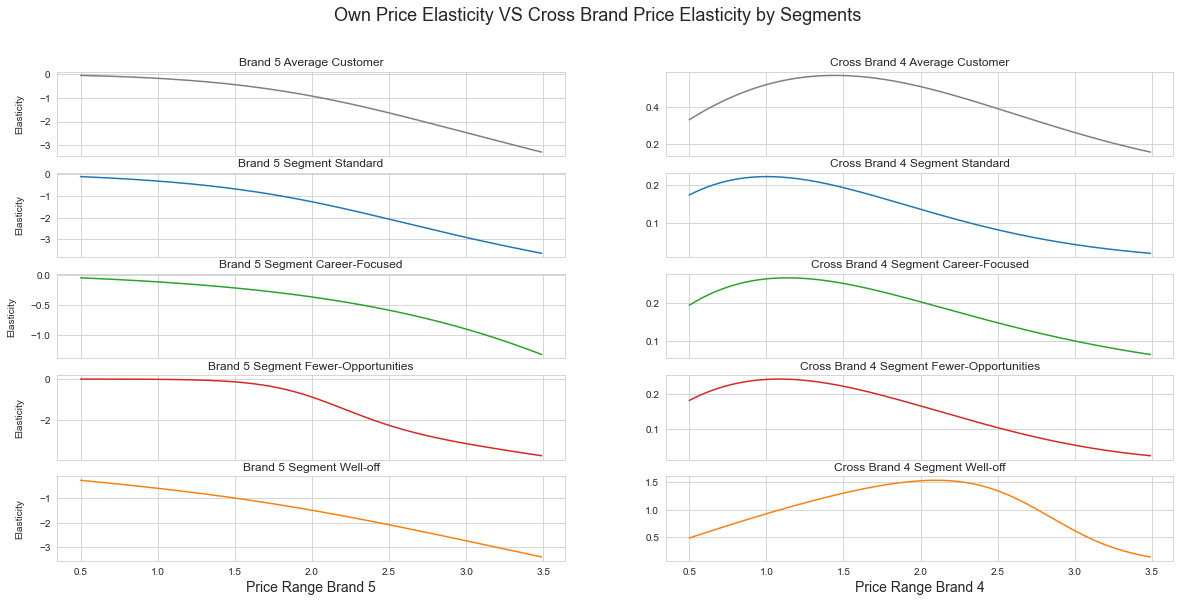

In [64]:
# We plot the own and cross brand price elasticities for the average customer and each of the four segments.
# We can observe differences and similiraties between the segments and examine their preference, when it comes to brand choice.
# The two segments, which seem to be of most interested for the marketing team of brand 5, seem to be the Career-focused
# and the Well-off. They are also the segments which purchase this brand most often. 
# The Career-focused segment is the most inelastic and they are the most loyal segment. 
# Based on our model, they do not seem to be that affected by price, therefore brand 5 could increase its price, 
# without fear of significant loss of customers from this segment. 
# The Well-off segment on the other hand, seems to be more elastic. They also purchase the competitor brand 4 most often.
# In order to target this segment, our analysis signals, that price needs to be decreased. However, keep in mind 
# that other factors aside from price might be influencing the purchase behaivour of this segment.
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (20, 9), sharex = True)

ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity\n')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s0)
ax2[0].set_title('Brand 5 Segment Standard')
ax2[0].set_ylabel('Elasticity\n')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0)
ax2[1].set_title('Cross Brand 4 Segment Standard')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity\n')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax4[0].set_ylabel('Elasticity\n')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Well-off')
ax5[0].set_xlabel('Price Range Brand 5', fontsize=14)
ax5[0].set_ylabel('Elasticity\n')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Well-off')
ax5[1].set_xlabel('Price Range Brand 4', fontsize=14)

plt.suptitle("Own Price Elasticity VS Cross Brand Price Elasticity by Segments\n", fontsize=18)
plt.show()

We've plotted on price elasticities and cross price elasticities side by side. The first line represents the average customer, while the following lines represent the segments from 0 to 3. We chose this representation of the results as it will allow us to easily compare each of the four segments to one another.

Note that the x axes refer to the price of Brand five and price of brand four respectively. The Y axis reflect the on price elasticity or the cross price elasticity. As you can probably notice, they differ greatly among the different graphs, so we will have to pay special attention.

---

# ML Predictive Modeling - Purchase Quantity Estimation with and without Promotion using Linear Regression


$\hookrightarrow$ **How many units of the product category of interest will the customer buy?**

We're going to build a statistical model that estimates purchase quantity for each customer on each shopping trip. Then we're going to calculate the price elasticity of purchase quantity under different conditions.

So we are at the stage of the journey of the customer where they had visited the store, they had decided to purchase a product from the product category we're interested in, and they had decided which brand they're going to buy. What is left for them is to decide how many units they're going to buy.

Therefore, we'll need a regression model to solve the problem at hand. We'll employ linear regression, which has the advantage of being easily interpretable and widely used in the data science field.

## Price Elasticity of Purchase Quantity

In [65]:
# We want to determine price elasticity of purchase quantity, also known as price elasticity of demand.
# We are interested in purchase ocassion, where the purchased quantity is different from 0.
# Therefore, once again we filter our data to contain only shopping visits where the client has purchased at least one product.
df_purchase_quantity = df_pa[df_pa['Incidence'] == 1]
df_purchase_quantity.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0


In [66]:
# Create brand dummies, for each of the brands.
df_purchase_quantity = pd.get_dummies(df_purchase_quantity,
                                      columns=['Brand'],
                                      prefix='Brand',
                                      prefix_sep='_')

# The descriptive analysis of the purchase quantitiy data frame, shows that quantity ranges from 1 to 15 
# and has an average value of 2.8, which means that more often than not our customers buy more than 1 chocolate candy bar.
print("Quantity Column Statistical Description\n\n",
      df_purchase_quantity[['Quantity']].describe())

print("\nFacts: The Minimum and Maximum units bought: 1 & 15, with an average of 3 and a median of 2 items.")

Quantity Column Statistical Description

            Quantity
count  14638.000000
mean       2.774559
std        1.796736
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       15.000000

Facts: The Minimum and Maximum units bought: 1 & 15, with an average of 3 and a median of 2 items.


In [67]:
# Here we make a decission on which features to include in our model. We decide to include a Price and a Promotion feature.
print(", ".join(df_purchase_quantity.columns.tolist()))

ID, Day, Incidence, Quantity, Last_Inc_Brand, Last_Inc_Quantity, Price_1, Price_2, Price_3, Price_4, Price_5, Promotion_1, Promotion_2, Promotion_3, Promotion_4, Promotion_5, Sex, Marital status, Age, Education, Income, Occupation, Settlement size, Segment, Segment_0, Segment_1, Segment_2, Segment_3, Brand_1, Brand_2, Brand_3, Brand_4, Brand_5


The customers decision of how many units is influenced only by the price of the chosen brand and not the other brands. Therefore, we need to filter this information somehow. Let's create a new variable called price incidents, it will contain the price of the purchase for this particular incidents. What we need to know is which brand was chosen and what the price of that brand was. Remember that the brand column is a dummy variable, so only one value is 1 and the rest of the row are zeros, so when multiplying, we'll get the price of the chosen brand.


In [68]:
# Find the price of the product that is chosen at this incidence
df_purchase_quantity['Price_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Price_1'] +
                                           df_purchase_quantity['Brand_2'] * df_purchase_quantity['Price_2'] +
                                           df_purchase_quantity['Brand_3'] * df_purchase_quantity['Price_3'] +
                                           df_purchase_quantity['Brand_4'] * df_purchase_quantity['Price_4'] +
                                           df_purchase_quantity['Brand_5'] * df_purchase_quantity['Price_5'] )

Also we've got promotion and it's another important factor that may influence the decision about how many units the customers buy. Let's create one more new variable which indicates whether the chosen brand is on promotion or not similar to the price incidents variable. It will be equal to the sum of the products of each brand dummy variables and the respective promotion variable. As a result will get an indicator variable which will have a value of 1 if the chosen bran is on promotion and value of 0 if the chosen brand was not on promotion.

In [69]:
# Find the price of the product that is chosen at this incidence
df_purchase_quantity['Promotion_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Promotion_1'] +
                                               df_purchase_quantity['Brand_2'] * df_purchase_quantity['Promotion_2'] +
                                               df_purchase_quantity['Brand_3'] * df_purchase_quantity['Promotion_3'] +
                                               df_purchase_quantity['Brand_4'] * df_purchase_quantity['Promotion_4'] +
                                               df_purchase_quantity['Brand_5'] * df_purchase_quantity['Promotion_5'] )

## Model Estimation - Linear Regression

In [70]:
X = df_purchase_quantity[['Price_Incidence', 'Promotion_Incidence']]
X

,Price_Incidence,Promotion_Incidence
6,1.90,0
11,2.62,1
19,1.47,0
24,2.16,0
29,1.88,0
...,...,...
58621,1.89,0
58648,1.35,1
58674,1.85,1
58687,1.51,0


In [71]:
y = df_purchase_quantity['Quantity']
y

6         2
11        1
19        2
24        1
29        3
         ..
58621     6
58648    12
58674     7
58687     6
58691     3
Name: Quantity, Length: 14638, dtype: int64

In [72]:
# Linear Regression Model
model_quantity = LinearRegression()
model_quantity.fit(X, y)

LinearRegression()

In [73]:
# Linear Regression Model. The coefficients for price and promotion are both negative. 
# It appears that promotion reflects negatively on the purchase quantity of the average client, which is unexpected.
model_quantity.coef_

array([-0.8173651 , -0.10504673])

The first coefficient refers to price incidents while the second two promotion incidents. Here's the interpretation.

First let's start with the price coefficient, every dollar increase in price, about 0.82 units less chocolate candy bars would be bought naturally. **As price increases, purchase quantity decreases**.

Then if there is a promotion, about 0.11 units less will be bought. Interestingly, **people would buy a bit less if there is a promotion**. This may be explained by the fact that our model is quite simplified, given that we've only got two predictors. Maybe some important information is missing in our data set. Another plausible explanation is related to the fact that we are considering the average customer and not any particular segment. Or it may well be that a promotion is prompting a customer to try out a new brand In that case, we would not expect them to buy many chocolate bars, but a single one.

With these in mind, it is time to calculated the price elasticities.

## Price Elasticity with Promotion

We will calculate price elasticity of purchase quantity, price elasticity of purchase quantity is the percentage change in purchase quantity in response to a 1% change in the unit price of the chosen brand. Assuming nothing else but the price changes in economics, price elasticity is most often associated with price elasticity of demand. We'll assume that the price can change across a wide range of values will calculate purchase quantity across the price range using the purchase quantity model we estimated then will calculate price elasticity across the price range.

In [74]:
# We examine the price elasticity of purchase quantity with active promotional activities for each price point.
df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Promotion_Incidence'] = 1

Now, let's move on to the elasticity calculation. As you can guess, the formula is different. Once again, the price elasticity of purchase quantity is equal to the ratio of the difference in purchase quantity to purchase quantity divided by the ratio of difference in price to price.

$$E = \frac{\frac{\Delta Quantity(purchase)}{Quantity(purchase)}}{\frac{\Delta Price}{Price}} = \beta·\frac{Price}{Quantity(purchase)}$$

In [75]:
# Requirements for price elasticity formula

# Take the coefficient for price.
beta_quantity = model_quantity.coef_[0]

# Predict quanity(purchase)
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

In [76]:
# We calculate the price elasticity with our new formula.
price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity

In [77]:
# Append price elasticity to dataframe
df_price_elasticities['PE_Quantity_Promotion_1'] = price_elasticity_quantity_promotion_yes
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1
0,0.50,-0.096305,-0.211792,-0.119463,-0.030855,-0.168029,-0.125725,-0.195632,-0.048965,0.331402,-0.115598,0.173763,-0.043860,0.194409,-0.001034,0.181262,-0.296776,0.481536,-0.102157
1,0.51,-0.100368,-0.218378,-0.123659,-0.032618,-0.172953,-0.129841,-0.201753,-0.050523,0.336668,-0.118631,0.175815,-0.044944,0.196888,-0.001096,0.183555,-0.302811,0.490824,-0.104413
2,0.52,-0.104558,-0.225072,-0.127948,-0.034468,-0.177948,-0.134036,-0.207976,-0.052111,0.341878,-0.121699,0.177815,-0.046038,0.199317,-0.001161,0.185799,-0.308856,0.500097,-0.106679
3,0.53,-0.108877,-0.231874,-0.132333,-0.036409,-0.183013,-0.138310,-0.214302,-0.053728,0.347030,-0.124802,0.179765,-0.047142,0.201695,-0.001229,0.187994,-0.314912,0.509354,-0.108954
4,0.54,-0.113330,-0.238786,-0.136814,-0.038444,-0.188149,-0.142666,-0.220733,-0.055375,0.352126,-0.127941,0.181665,-0.048255,0.204023,-0.001300,0.190141,-0.320979,0.518595,-0.111238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.008319,-5.050911,-5.683827,-12.544006,-4.021566,-4.861224,-4.982859,-3.225642,0.161937,-3.585866,0.024015,-1.285058,0.068469,-3.739207,0.023364,-3.331187,0.157190,-1.774292
296,3.46,-8.033562,-5.067756,-5.703978,-12.580930,-4.036432,-4.879425,-4.999764,-3.241806,0.160041,-3.599745,0.023659,-1.294848,0.067847,-3.750628,0.022905,-3.344493,0.151778,-1.788634
297,3.47,-8.058770,-5.084583,-5.724092,-12.617837,-4.051282,-4.897596,-5.016650,-3.257938,0.158158,-3.613580,0.023308,-1.304694,0.067230,-3.762029,0.022453,-3.357795,0.146532,-1.803124
298,3.48,-8.083944,-5.101392,-5.744170,-12.654728,-4.066115,-4.915736,-5.033516,-3.274038,0.156290,-3.627370,0.022961,-1.314595,0.066617,-3.773411,0.022009,-3.371095,0.141446,-1.817766


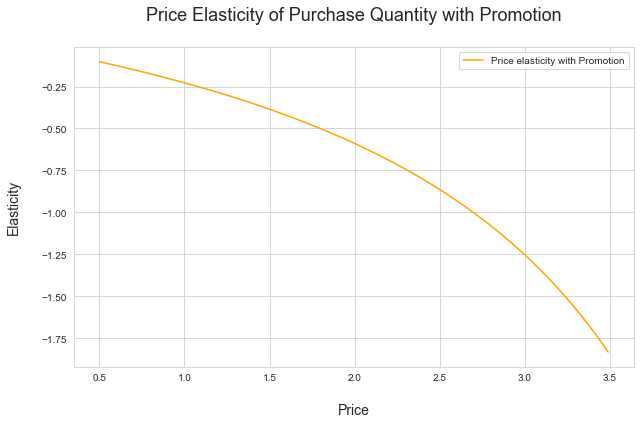

In [85]:
# Plot the two elasticities side by side. 
# We observe that the two elasticities are very close together for almost the entire price range.
# It appears that promotion does not appear to be a significant factor in the customers' decission 
# what quantity of chocolate candy bars to purchase.
plt.figure(figsize = (9, 6))
plt.plot(price_range,
         price_elasticity_quantity_promotion_yes,
         color='orange',
         label="Price elasticity with Promotion")
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Quantity with Promotion\n', fontsize=18)
plt.tight_layout()
plt.legend()
plt.show()

## Price Elasticity without Promotion

In [81]:
# Overwrite promotion incidence in order to use the same df. 
# Here we assume there are no promotinal activities active for the entire price range.
df_price_elasticity_quantity['Promotion_Incidence'] = 0
# Find the new predicted quantities.
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)
# Calculate the new price elasticities.
price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity
# Add the results to the master data frame.
df_price_elasticities['PE_Quantity_Promotion_0'] = price_elasticity_quantity_promotion_no
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1,PE_Quantity_Promotion_0
0,0.50,-0.096305,-0.211792,-0.119463,-0.030855,-0.168029,-0.125725,-0.195632,-0.048965,0.331402,-0.115598,0.173763,-0.043860,0.194409,-0.001034,0.181262,-0.296776,0.481536,-0.102157,-0.099543
1,0.51,-0.100368,-0.218378,-0.123659,-0.032618,-0.172953,-0.129841,-0.201753,-0.050523,0.336668,-0.118631,0.175815,-0.044944,0.196888,-0.001096,0.183555,-0.302811,0.490824,-0.104413,-0.101736
2,0.52,-0.104558,-0.225072,-0.127948,-0.034468,-0.177948,-0.134036,-0.207976,-0.052111,0.341878,-0.121699,0.177815,-0.046038,0.199317,-0.001161,0.185799,-0.308856,0.500097,-0.106679,-0.103939
3,0.53,-0.108877,-0.231874,-0.132333,-0.036409,-0.183013,-0.138310,-0.214302,-0.053728,0.347030,-0.124802,0.179765,-0.047142,0.201695,-0.001229,0.187994,-0.314912,0.509354,-0.108954,-0.106150
4,0.54,-0.113330,-0.238786,-0.136814,-0.038444,-0.188149,-0.142666,-0.220733,-0.055375,0.352126,-0.127941,0.181665,-0.048255,0.204023,-0.001300,0.190141,-0.320979,0.518595,-0.111238,-0.108369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.008319,-5.050911,-5.683827,-12.544006,-4.021566,-4.861224,-4.982859,-3.225642,0.161937,-3.585866,0.024015,-1.285058,0.068469,-3.739207,0.023364,-3.331187,0.157190,-1.774292,-1.664290
296,3.46,-8.033562,-5.067756,-5.703978,-12.580930,-4.036432,-4.879425,-4.999764,-3.241806,0.160041,-3.599745,0.023659,-1.294848,0.067847,-3.750628,0.022905,-3.344493,0.151778,-1.788634,-1.677205
297,3.47,-8.058770,-5.084583,-5.724092,-12.617837,-4.051282,-4.897596,-5.016650,-3.257938,0.158158,-3.613580,0.023308,-1.304694,0.067230,-3.762029,0.022453,-3.357795,0.146532,-1.803124,-1.690246
298,3.48,-8.083944,-5.101392,-5.744170,-12.654728,-4.066115,-4.915736,-5.033516,-3.274038,0.156290,-3.627370,0.022961,-1.314595,0.066617,-3.773411,0.022009,-3.371095,0.141446,-1.817766,-1.703414


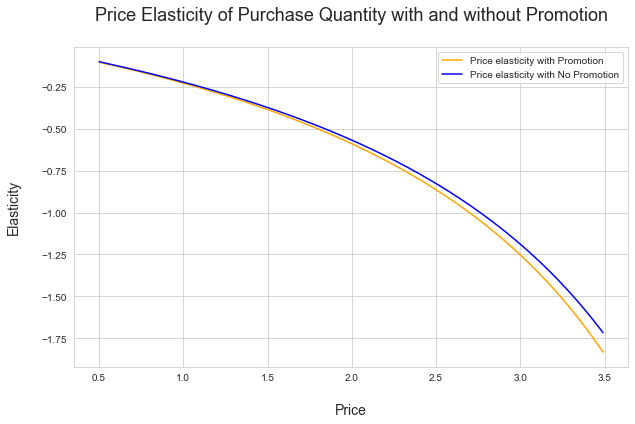

In [83]:
# Plot the two elasticities side by side. 
# We observe that the two elasticities are very close together for almost the entire price range.
# It appears that promotion does not appear to be a significant factor in the customers' decission 
# what quantity of chocolate candy bars to purchase.
plt.figure(figsize = (9, 6))
plt.plot(price_range,
         price_elasticity_quantity_promotion_yes,
         color='orange',
         label="Price elasticity with Promotion")

plt.plot(price_range,
         price_elasticity_quantity_promotion_no,
         color='blue',
         label="Price elasticity with No Promotion")
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Quantity with and without Promotion\n', fontsize=18)
plt.tight_layout()
plt.legend()
plt.show()